# Laboratory 04
**Localization of a robot with Extended Kalman Filter**

---
## Objective

- Implement the equation of the EKF in a Python script
- Run a localization simulation with the implemented script
- Understand the influence of parameters of the EKF


---

## NumPy Usage

NumPy is a fundamental Python library for numerical computing. It stands for Numerical Python and offers powerful tools and data structures, primarily multidimensional arrays (ndarrays), along with a collection of mathematical functions to operate on these arrays. NumPy provides efficient methods for manipulating large datasets and performing a wide range of mathematical computations, including linear algebra, Fourier analysis, statistics, random number generation, and more. Its versatility, speed, and ease of use make it a pillar in various fields such as scientific computing, data analysis and machine learning.

In the following cells are reported some common operations that can be performed on array and matrices using this library.

##### Import NumPy and create a simple array


In [757]:
import numpy as np
np.set_printoptions(precision=5)
                      
arr = np.array([[1,2,3,4]])
print(f"arr: {arr}") 
print(f"shape: {arr.shape}") # with the shape attribute, we can see the dimension of the array (rows, columns)

arr: [[1 2 3 4]]
shape: (1, 4)


##### Transpose a matrix or an array

In [758]:
arrT = arr.T
print(f"arrT: \n{arrT},\nshape: {arrT.shape}")

arrT: 
[[1]
 [2]
 [3]
 [4]],
shape: (4, 1)


##### Matrix Multiplication
The `@` perform a matrix multiplication, so the order of the operands it is relevant. I reported here an example of multiplying $A^T A $ and $ A A^T$.

In [759]:
print(arrT @ arr)

print(arr @ arrT)

[[ 1  2  3  4]
 [ 2  4  6  8]
 [ 3  6  9 12]
 [ 4  8 12 16]]
[[30]]


##### Inverse of a Matrix

In [760]:
from numpy.linalg import inv # this operator is used to compute the inverse of a matrix

square_mat = np.array([[1,2],[3,4]]) # create a 2x2 matrix
print(square_mat)
print(inv(square_mat)) # compute the inverse of the matrix
print(square_mat @ inv(square_mat)) # compute the product of the matrix and its inverse (should be the identity matrix)

[[1 2]
 [3 4]]
[[-2.   1. ]
 [ 1.5 -0.5]]
[[1.00000e+00 0.00000e+00]
 [8.88178e-16 1.00000e+00]]


##### Slicing

Get an element, rows or columns from a matrix. Similar to MATLAB but remember that the indexes starts from 0.

In [761]:
# get element at row 0, column 1
print(square_mat[0,1])

# get row 0
print(square_mat[0,:])

# get column 1
print(square_mat[:,1])

2
[1 2]
[2 4]


---
## SymPy Usage

SymPy is a Python library used for symbolic mathematics. It aims to become a full-featured computer algebra system while keeping the code as simple as possible in order to be comprehensible and easily extensible. SymPy includes features ranging from basic symbolic arithmetic to calculus, algebra, discrete mathematics and quantum physics.

We will use this library to write measurement and motion models and to evaluate easily their Jacobians.

In [762]:
# Import the module and the most relevant functions
import sympy
sympy.init_printing(use_latex='mathjax')
from sympy import symbols, Matrix, latex

In [763]:
# Create the symbolic variables
a, b, c, d = symbols('a b c d')

# Create a Matrix using the symbolic variables
my_matrix = Matrix([[2*a/d], [b*sympy.sin(c)]])
my_matrix

⎡  2⋅a   ⎤
⎢  ───   ⎥
⎢   d    ⎥
⎢        ⎥
⎣b⋅sin(c)⎦

In [764]:
# Compute the Jacobian of the matrix with respect to a vector
jac = my_matrix.jacobian(Matrix([a, b, c, d]))
jac

⎡2                    -2⋅a ⎤
⎢─    0        0      ─────⎥
⎢d                       2 ⎥
⎢                       d  ⎥
⎢                          ⎥
⎣0  sin(c)  b⋅cos(c)    0  ⎦

In [765]:
# Transform the symbolic Matrix in a function that can be evaluated numerically
eval_my_matrix = sympy.lambdify((a, b, c, d), my_matrix, 'numpy')
eval_my_matrix(a=1, b=2, c=3, d=4) # also eval_my_matrix(1, 2, 3, 4)

array([[0.5    ],
       [0.28224]])

In [766]:
# Ypu can do the same for the Jacobian
eval_jac = sympy.lambdify((a, b, c, d), jac, 'numpy')
eval_jac(1, 2, 3, 4)

array([[ 0.5    ,  0.     ,  0.     , -0.125  ],
       [ 0.     ,  0.14112, -1.97998,  0.     ]])

---
## Velocity Motion Model

Using the SymPy library implement the Velocity Motion Model that is explained in the lecture slides. For clearness the main equation of the model is reported below.

$$
\begin{pmatrix} x' \\ y' \\ \theta' \end{pmatrix} = g(u_t,x_{t-1}) + \mathcal{N}(0, R_t)= 
\begin{pmatrix} x \\ y \\ \theta \end{pmatrix} + 
\begin{pmatrix} 
- \frac{v_t}{\omega_t }\sin{\theta} + \frac{v_t}{\omega_t }\sin{( \theta + \omega_t \Delta t )} \\
\frac{v_t}{\omega_t }\cos{\theta} - \frac{v_t}{\omega_t }\cos{(\theta + \omega_t \Delta t)} \\
\omega_t \Delta t
\end{pmatrix} + \mathcal{N}(0, R_t)
$$

Then, use the function provided by SymPy to derive the Jacobian matrices w.r.t the state $G_t$ and the input $V_t$ and create a function to evaluate it.

In [767]:
x, y, theta, v, w, dt = symbols('x y theta v w dt')
gux = Matrix([[x + v/w*sympy.sin(theta + w*dt) - v/w*sympy.sin(theta)], 
              [y + v/w*sympy.cos(theta) - v/w*sympy.cos(theta + w*dt)], 
              [theta + w*dt]])
gux

⎡  v⋅sin(θ)   v⋅sin(dt⋅w + θ)    ⎤
⎢- ──────── + ─────────────── + x⎥
⎢     w              w           ⎥
⎢                                ⎥
⎢ v⋅cos(θ)   v⋅cos(dt⋅w + θ)     ⎥
⎢ ──────── - ─────────────── + y ⎥
⎢    w              w            ⎥
⎢                                ⎥
⎣            dt⋅w + θ            ⎦

In [768]:
eval_gux = sympy.lambdify((x, y, theta, v, w, dt), gux, 'numpy')

In [769]:
Gt = gux.jacobian(Matrix([x, y, theta]))
eval_Gt = sympy.lambdify((x, y, theta, v, w, dt), Gt, 'numpy')
Vt = gux.jacobian(Matrix([v, w]))
eval_Vt = sympy.lambdify((x, y, theta, v, w, dt), Vt, 'numpy')

---
## Landmarks Measurement Model

As a measurement model we will use **landmarks** described by distance and bearing w.r.t. the robot current pose.

$$
h(x, m) = 
\left(
    \begin{matrix}
    \sqrt{\left(m_x - x\right)^{2} + \left(m_y - y\right)^{2}}\\
    \operatorname{atan2}{\left(m_y - y,m_x - x \right)} - \theta
    \end{matrix}
\right)
$$

Write in the following cell the code to compute the measurement and its Jacobian w.r.t. to the state. Remember to convert the symbolic functions to Python functions that can be evaluated as done in the previous step.

In [770]:
mx, my = symbols('mx my')
hx = Matrix([[sympy.sqrt((mx - x)**2 + (my - y)**2)], [sympy.atan2(my - y, mx - x) - theta]])
eval_hx = sympy.lambdify((x, y, theta, mx, my), hx, 'numpy')

In [771]:
Ht = hx.jacobian(Matrix([x, y, theta]))
eval_Ht = sympy.lambdify((x, y, theta, mx, my), Ht, 'numpy')

---
## EKF Implementation

Complete the `RobotEKF` Class with the filter equations where you find the symbol `...`


#### Filter Initialization

In the function `__init__` the filter is initialized given the dimensions of the state `dim_x`, of the input `dim_u` and of the measurement `dim_z`.

You must pass as arguments:
- `dim_x`: the dimension of the state vector
- `dim_z`: the dimension of the measurement vector
- `dim_u`: the dimension of the input vector
- `eval_gux`, `eval_Gt`, `eval_Vt`: the functions to evaluate the motion model and it Jacobians
- `eval_hx`, `eval_Ht`: the functions to evaluate the measurement model and its Jacobian

In [772]:
import math

class RobotEKF:
    def __init__(
        self,
        dim_x=1, dim_z=1, dim_u=1,
        eval_gux=None, eval_Gt=None, eval_Vt=None,
        eval_hx=None, eval_Ht=None,
    ):
        """
        Initializes the extended Kalman filter creating the necessary matrices
        """
        self.mu = np.zeros((dim_x, 1))  # mean state estimate
        self.Sigma = np.eye(dim_x)  # covariance state estimate
        self.Mt = np.eye(dim_u)  # process noise
        self.Qt = np.eye(dim_z)  # measurement noise

        self.eval_gux = eval_gux
        self.eval_Gt = eval_Gt
        self.eval_Vt = eval_Vt

        self.eval_hx = eval_hx
        self.eval_Ht = eval_Ht

        self._I = np.eye(dim_x)  # identity matrix used for computations

#### Prediction Step

The function `predict` implement the prediction step of the EKF given an input and a time interval.

Complete where you find the symbol `...` using the equations of the EKF

$$
\begin{aligned}
\bar{\mu}_t =& g(u_t, \mu_{t-1}) \\
\bar{\Sigma}_t =& G_t \Sigma_{t-1} G_t^T + V_t M_t V_t^T
\end{aligned}
$$

  The argument `g_extra_args` is a tuple of all the arguments different from $\mu_{t-1}$ and $u_t$ to evaluate the motion model, e.g. $\Delta t$ for the velocity motion model.


In [773]:
def predict(self, u, g_extra_args=()):
    """
    Update the state prediction using the control input u and compute the relative uncertainty ellipse

    Modified variables:
        self.mu: the state prediction
        self.Sigma: the covariance matrix of the state prediction
    """
    # Update the state prediction evaluating the motion model
    self.mu = self.eval_gux(*self.mu[:,0], *u[:,0], *g_extra_args)
    
    # Update the covariance matrix of the state prediction, 
    # you need to evaluate the Jacobians Gt and Vt
    Gt = self.eval_Gt(*self.mu[:,0], *u[:,0], *g_extra_args)
    Vt = self.eval_Vt(*self.mu[:,0], *u[:,0], *g_extra_args)
    self.Sigma = Gt @ self.Sigma @ Gt.T + Vt @ self.Mt @ Vt.T

RobotEKF.predict = predict

#### Measurement Update Step

The function `update` compute the posterior of the filter given a measure `z`, a measurement model `hx` and its Jacobian `H`.

Complete the function where you find the symbol `...` with the posterior update equations of the EKF.

$$
\begin{aligned}
S_t^i &= H_t^i \bar{\Sigma}_t [H_t^i]^T + Q_t \\
K_i^t &= \bar{\Sigma}_t [H_t^i]^T [S_t^i]^{-1} \\
\mu_t &= \bar{\mu}_t + K^i_t(z^i_t - \hat{z}_t^i) \\
\Sigma_t &= (I - K^i_t H^i_t) \bar{\Sigma}_t
\end{aligned}
$$

The argument `h_extra_args` is a tuple of all the arguments different from $\bar \mu_t$ to evaluate the measurement model, e.g. the landmark position.

In [774]:
def update(self, z, lmark, residual=np.subtract):
    """Performs the update innovation of the extended Kalman filter.

    Parameters
    ----------

    z : np.array
        measurement for this step.

    lmark : [x, y] list-like
        Landmark location in cartesian coordinates.

    residual : function (z, z2), optional
        Optional function that computes the residual (difference) between
        the two measurement vectors. If you do not provide this, then the
        built in minus operator will be used. You will normally want to use
        the built in unless your residual computation is nonlinear (for
        example, if they are angles)
    """
    
    # Convert the measurement to a vector if necessary. Needed for the residual computation
    if np.isscalar(z) and self.dim_z == 1:
        z = np.asarray([z], float)

    # Compute the Kalman gain, you need to evaluate the Jacobian Ht
    Ht = self.eval_Ht(*self.mu[:,0], *lmark)
    self.S = Ht @ self.Sigma @ Ht.T + self.Qt
    self.K = self.Sigma @ Ht.T @ inv(self.S)

    # Evaluate the expected measurement and compute the residual, then update the state prediction
    z_hat = self.eval_hx(*self.mu[:,0], *lmark)

    self.y = residual(z[:, 0], z_hat[:, 0])
    self.mu = self.mu + self.K @ (z - z_hat)

    # P = (I-KH)P(I-KH)' + KRK' is more numerically stable and works for non-optimal K vs the equation
    # P = (I-KH)P usually seen in the literature. 
    # Note that I is the identity matrix.
    I_KH = self._I - self.K @ Ht
    self.Sigma = I_KH @ self.Sigma @ I_KH.T + self.K @ self.Qt @ self.K.T

RobotEKF.update = update

---
## Measurement Simulator

This function simulate the measurement of a landmark adding noise to the value computed with the measurement model. 

The sensor has a Field of View (FOV) of 180° and a maximum range of 15 meters, i.e. only the landmarks reasonably in the robot's view can be used to correct the filter.

Fill the `...` with the arguments to evaluate the function.

In [775]:
from numpy.random import randn # function to get a random number from a Gaussian distribution

def z_landmark(x, lmark, std_rng=0.5, std_brg=0.5):
    """
    Simulate the measurement of a landmark adding some Gaussian noise

    Args:
        x [np.array]: the position of the robot with shape (dim_x, 1)
        lmark [np.array or List]: the position of the landmark, eg. [x, y]
        std_rng [float]: the standard deviation of the range measurement
        std_brg [float]: the standard deviation of the bearing measurement
    Returns:
        z [np.array]: the measurement of the landmark
    """
    z = eval_hx(*x, *lmark)

    # filter z for a more realistic sensor simulation (add a max range distance and a FOV)
    fov = np.deg2rad(45)
    if z[0, 0] < 8.0 and abs(z[1, 0])<fov:
        return z + np.array([[randn() * std_rng**2, randn() * std_brg]]).T
        
    return None

Now we have another issue to handle. The residual is notionally computed as $y = z - h(x)$ but this will not work because our measurement contains an angle in it. Suppose z has a bearing of $1^\circ$ and $h(x)$ has a bearing of $359^\circ$. Naively subtracting them would yield a angular difference of $-358^\circ$, whereas the correct value is $2^\circ$. We have to write code to correctly compute the bearing residual.

In [776]:
def residual(a, b):
    """
    Compute the residual between measuremnts, normalizing angles between [-pi, pi)

    Returns:
        y [np.array] : the residual between the two states
    """
    
    y = a - b
    y[1] = y[1] % (2 * np.pi)  # force in range [0, 2 pi)
    if y[1] > np.pi:  # move to [-pi, pi)
        y[1] -= 2 * np.pi
    return y

---
<a id='simulator1'></a>

## Simulator

The following function implements a simple simulator that you can use to test your filters. It deals with three tasks:

- **simulate the robot** evaluating the motion model at a frequency higher w.r.t. the update rate of the EKF, defined by the parameter `sim_step_s`
- **run the EKF** at its expected frequency `ekf_dt`
- **plot** the simulated (real) path and the positions estimated by the EKF with the prior and posterior covariances

Complete the functions where you find `...`

In [777]:
from utils import plot_covariance
import matplotlib.pyplot as plt


def run_localization(
    ekf: RobotEKF,
    ekf_dt,
    landmarks,
    std_lin_vel,
    std_ang_vel,
    std_range,
    std_bearing,
    sim_step_s=0.1,
    ellipse_step_s=5.0,
    sim_length_s=1,
):
    sim_pos = ekf.mu.copy()  # simulated position, copy the initial position set inside the EKF
    odom_pos = ekf.mu.copy()  # odometry position, copy the initial position set inside the EKF
    sim_noise_generator = np.random.default_rng(42424242)  # random noise generator

    cmd_vel = np.array(
        [[1.10, 0.05]]
    ).T  # velocity command (v, omega). In this case will be constant for the whole simulation

    # convert the durations to number of time steps
    steps = int(sim_length_s / sim_step_s)
    ekf_step = int(ekf_dt / sim_step_s)
    ellipse_step = int(ellipse_step_s / sim_step_s)

    # Initialize a plot and insert the landmarks
    fig, ax = plt.subplots(1, 2, figsize=(9, 4))
    lmarks_legend = ax[0].scatter(landmarks[:, 0], landmarks[:, 1], marker="s", s=60, label="Landmarks")

    track = []  # list to store all the robot positions
    track_odom = []  # list to store all the odometry positions
    track_ekf = [ekf.mu.copy()]  # list to store all the ekf positions

    # The main loop that runs the simulation
    for i in range(steps):
        if i != 0 and i % sim_N == 0:
            cmd_vel = cmd_vel + np.array([[0.1, -0.5]])
        # to simulate the error in the actuation of the robot, we add some Gaussian noise to the velocity command
        noisy_vel = cmd_vel + np.array([[std_lin_vel, std_ang_vel]]).T * sim_noise_generator.normal(size=(2, 1))
        # Simulate robot motion for sim_step_s seconds using the Velocity Motion Model.
        # Complete with the correct data to evaluate the motion model, use the noisy_vel variable
        sim_pos = eval_gux(*sim_pos[:,0], *noisy_vel[:,0], sim_step_s) 
        track.append(sim_pos)

        # to simulate the error in the odometry reading, we take another Gaussian sample of the velocity command
        noisy_vel = cmd_vel + np.array([[std_lin_vel, std_ang_vel]]).T * sim_noise_generator.normal(size=(2, 1))
        # complete with the correct data to evaluate the motion model, use the noisy_vel variable
        odom_pos = eval_gux(*odom_pos[:,0], *noisy_vel[:,0], sim_step_s)
        track_odom.append(odom_pos)

        if i % ekf_step == 0 and i != 0:  # only update ekf at dt intervals
            # run the prediction step of the EKF
            ekf.predict(u=cmd_vel, g_extra_args=(ekf_dt,))

            if i % ellipse_step == 0:  # plot the prior covariance ellipses every ellipse_step_s seconds
                pri_ellipse = plot_covariance(
                    (ekf.mu[0, 0], ekf.mu[1, 0]),
                    ekf.Sigma[0:2, 0:2],
                    std=6,
                    facecolor="k",
                    alpha=0.4,
                    label="Predicted Cov",
                    ax=ax[0],
                )

            for lmark in landmarks:  # loop over each landmark
                z = z_landmark(sim_pos[:,0], lmark, std_range, std_bearing)  # simulate the measurement of the landmark

                # if any landmark detected by the sensor, update the EKF
                if z is not None:
                    # run the correction step of the EKF
                    ekf.update(z, lmark, residual=residual)

            if i % ellipse_step == 0:  # plot the posterior covariance ellipses every ellipse_step_s seconds
                post_ellipse = plot_covariance(
                    (ekf.mu[0, 0], ekf.mu[1, 0]),
                    ekf.Sigma[0:2, 0:2],
                    std=6,
                    facecolor="g",
                    alpha=0.8,
                    label="Corrected Cov",
                    ax=ax[0],
                )
            track_ekf.append(ekf.mu.copy())

    # draw plots
    track = np.array(track)
    track_odom = np.array(track_odom)
    track_ekf = np.array(track_ekf)
    
    # trajectory plots
    (track_legend,) = ax[0].plot(track[:, 0], track[:, 1], label="Real robot path")
    (track_odom_legend,) = ax[0].plot(track_odom[:, 0], track_odom[:, 1], "--", label="Odometry path")
    ax[0].axis("equal")
    ax[0].set_title("EKF Robot localization")
    ax[0].legend(handles=[lmarks_legend, track_legend, track_odom_legend, pri_ellipse, post_ellipse])

    # error plots
    ekf_err, =  ax[1].plot(
        np.arange(0, sim_length_s, ekf_dt), 
        np.linalg.norm(track[::ekf_step, :2] - track_ekf[:, :2], axis=1), 
        '-o',
        label="EKF error",
    )
    odom_err, = ax[1].plot(
        np.arange(0, sim_length_s, sim_step_s), 
        np.linalg.norm(track[:, :2] - track_odom[:, :2], axis=1), 
        label="Odometry error",
    )
    ax[1].legend(handles=[ekf_err, odom_err])
    ax[1].set_title("Robot path error")

    fig.suptitle("EKF Robot localization, Velocity Motion Model")
    fig.tight_layout()

    plt.show()

### Run the simulation
Here it an example of how to run the simulation. 
- Create a vector of landmarks positions
- Call the function that run the simulation passing all the arguments

To test if your code is working properly, run the code below without changing parameters. The expected output is reported below.


![Expected Output](./expected_output.png)

In [778]:
# Parameters
seed = 42  # because it is the answer to the Ultimate Question of Life, The Universe and Everything :)

landmarks = np.array([[5, 12], [10, 5], [15, 15], [10, 14], [6, 6], [12, 9]])  # standard landmarks
#landmarks = np.array([[5, 12], [15, 15], [12,9]])                              # sparse landmarks
#landmarks = np.array([[5, 12], [15, 18], [6,6]])                               # sparse landmarks with gap

ekf_dt = 0.5  # time interval between measurements [s]
sim_length_s = 15  # length of the simulation [s]
sim_N = 30

# set the seed to get the same results every time
std_lin_vel = 0.1  # [m/s]
std_ang_vel = np.deg2rad(1.0)  # [rad/s]
std_range = 0.3  # [m]
std_bearing = np.deg2rad(1.0)  # [rad]

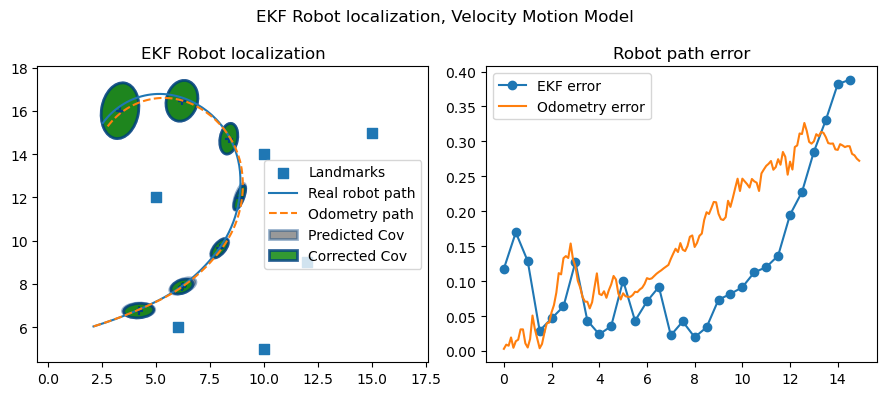

In [779]:
# set the seed to get the same results every time
np.random.seed(seed)

# Initialize the EKF
ekf = RobotEKF(
    dim_x=3,
    dim_z=2,
    dim_u=2,
    eval_gux=eval_gux,
    eval_Gt=eval_Gt,
    eval_Vt=eval_Vt,
    eval_hx=eval_hx,
    eval_Ht=eval_Ht,
)
ekf.mu = np.array([[2, 6, 0.3]]).T  # x, y, theta
ekf.Sigma = np.diag([0.1, 0.1, 0.1])
ekf.Mt = np.diag([std_lin_vel**2, std_ang_vel**2])
ekf.Qt = np.diag([std_range**2, std_bearing**2])


run_localization(
    ekf,
    ekf_dt=ekf_dt,
    landmarks=landmarks,
    std_lin_vel=std_lin_vel,
    std_ang_vel=std_ang_vel,
    std_range=std_range,
    std_bearing=std_bearing,
    ellipse_step_s=2.0,
    sim_length_s=sim_length_s,
)

---

## Odometry Motion Model

Implement the Odometry motion model described by the equations reported below.
1. Get the inputs $\delta_{rot1}$ , $\delta_{trasl}$, $\delta_{rot2}$ from the previous odometry reading $\bar x$ and the current odometry reading $\bar x'$
2. Implement the function $g(u_t,x_{t-1})$ to use this model inside an EKF

$$
\begin{align}
&\delta_{rot1} =& \operatorname{atan_{2}}{\left(\bar{y}'- \bar{y} ,\bar{x}' - \bar{x}  \right)} - \bar{\theta} \\
&\delta_{trasl} =& \sqrt{\left(\bar{x}' - \bar{x} \right)^{2} + \left(\bar{y}' - \bar{y} \right)^{2}} \\
&\delta_{rot2} =& \bar{\theta}' - \delta_{rot1} - \bar{\theta} \\
\end{align}
$$

$$
\begin{pmatrix}
x_t \\ y_t \\ \theta_t
\end{pmatrix} = g(u_t,x_{t-1}) + \mathcal{N}(0, R_t) = 
\begin{pmatrix}
x_{t-1} \\ y_{t-1} \\ \theta_{t-1}
\end{pmatrix} + 
\left(
    \begin{matrix}
    \delta_{trasl} \cos{\left(\delta_{rot1} + \theta \right)} \\
    \delta_{trasl} \sin{\left(\delta_{rot1} + \theta \right)} \\
    \delta_{rot1} + \delta_{rot2}
    \end{matrix} 
\right) + \mathcal{N}(0, R_t)
$$

In [780]:
def get_odometry_input(x, x_prev):
    rot1 = np.arctan2(x[1] - x_prev[1], x[0] - x_prev[0]) - x_prev[2]
    trasl = np.sqrt((x[0] - x_prev[0])**2 + (x[1] - x_prev[1])**2)
    rot2 = x[2] - x_prev[2] - rot1
    return np.array([[rot1, trasl, rot2]]).T

In [781]:
x, y, theta, rot1, trasl, rot2 = symbols('x y theta rot1 trasl rot2')

gux_odom = Matrix([[x + trasl*sympy.cos(theta + rot1)],
                   [y + trasl*sympy.sin(theta + rot1)],
                   [theta + rot1 + rot2]])
Gt_odom = gux_odom.jacobian(Matrix([x, y, theta]))
Vt_odom = gux_odom.jacobian(Matrix([rot1, trasl, rot2]))

eval_gux_odom = sympy.lambdify((x, y, theta, rot1, trasl, rot2), gux_odom, 'numpy')
eval_Gt_odom = sympy.lambdify((x, y, theta, rot1, trasl, rot2), Gt_odom, 'numpy')
eval_Vt_odom = sympy.lambdify((x, y, theta, rot1, trasl, rot2), Vt_odom, 'numpy')

--- 

## Simulator (with Odometry motion model)

This function is very similar to the previous simulator but there are some small changes in the prediction step where it is used the function `get_odometry_input` and the previous odometry position is stored for the next iteration.

In [782]:
def run_localization_odom(
    ekf: RobotEKF,
    ekf_dt,
    landmarks,
    std_lin_vel,
    std_ang_vel,
    std_range,
    std_bearing,
    sim_step_s=0.1,
    ellipse_step_s=5.0,
    sim_length_s=1,
):
    sim_pos = ekf.mu.copy()  # simulated position, copy the initial position set inside the EKF
    odom_pos = ekf.mu.copy()  # odometry position, copy the initial position set inside the EKF
    sim_noise_generator = np.random.default_rng(42424242)  # random noise generator

    cmd_vel = np.array(
        [[1.10, 0.05]]
    ).T  # velocity command (v, omega). In this case will be constant for the whole simulation

    # convert the durations to number of time steps
    steps = int(sim_length_s / sim_step_s)
    ekf_step = int(ekf_dt / sim_step_s)
    ellipse_step = int(ellipse_step_s / sim_step_s)

    # Initialize a plot and insert the landmarks
    fig, ax = plt.subplots(1, 2, figsize=(9, 4))
    lmarks_legend = ax[0].scatter(landmarks[:, 0], landmarks[:, 1], marker="s", s=60, label="Landmarks")

    track = []  # list to store all the robot positions
    track_odom = []  # list to store all the odometry positions
    track_ekf = [ekf.mu.copy()]  # list to store all the ekf positions

    odom_pos_prev = odom_pos.copy()

    # The main loop that runs the simulation
    for i in range(steps):
        if i != 0 and i % sim_N == 0:
            cmd_vel = cmd_vel + np.array([[0.1, -0.5]])
        # to simulate the error in the actuation of the robot, we add some Gaussian noise to the velocity command
        noisy_vel = cmd_vel + np.array([[std_lin_vel, std_ang_vel]]).T * sim_noise_generator.normal(size=(2, 1))
        # Simulate robot motion for sim_step_s seconds using the Velocity Motion Model.
        # Complete with the correct data to evaluate the motion model
        sim_pos = eval_gux(*sim_pos[:,0], *noisy_vel[:,0], sim_step_s)
        track.append(sim_pos)

        # to simulate the error in the odometry reading, we take another Gaussian sample of the velocity command
        noisy_vel = cmd_vel + np.array([[std_lin_vel, std_ang_vel]]).T * sim_noise_generator.normal(size=(2, 1))
        odom_pos = eval_gux(*odom_pos[:,0], *noisy_vel[:,0], sim_step_s)
        track_odom.append(odom_pos)

        if i != 0 and i % ekf_step == 0:  # only update ekf at dt intervals
            # run the prediction step of the EKF
            u = get_odometry_input(odom_pos[:,0], odom_pos_prev[:,0])
            ekf.predict(u=u)
            odom_pos_prev = odom_pos.copy()

            if i % ellipse_step == 0:  # plot the prior covariance ellipses every ellipse_step_s seconds
                pri_ellipse = plot_covariance(
                    (ekf.mu[0, 0], ekf.mu[1, 0]),
                    ekf.Sigma[0:2, 0:2],
                    std=6,
                    facecolor="k",
                    alpha=0.4,
                    label="Predicted Cov",
                    ax=ax[0],
                )

            for lmark in landmarks:  # loop over each landmark
                z = z_landmark(sim_pos[:,0], lmark, std_range, std_bearing)  # simulate the measurement of the landmark

                # if any landmark detected by the sensor, update the EKF
                if z is not None:
                    # run the correction step of the EKF
                    ekf.update(z, lmark, residual=residual)

            if i % ellipse_step == 0:  # plot the posterior covariance ellipses every ellipse_step_s seconds
                post_ellipse = plot_covariance(
                    (ekf.mu[0, 0], ekf.mu[1, 0]),
                    ekf.Sigma[0:2, 0:2],
                    std=6,
                    facecolor="g",
                    alpha=0.8,
                    label="Corrected Cov",
                    ax=ax[0],
                )
            track_ekf.append(ekf.mu.copy())

    # draw plots
    track = np.array(track)
    track_odom = np.array(track_odom)
    track_ekf = np.array(track_ekf)
    
    # trajectory plots
    (track_legend,) = ax[0].plot(track[:, 0], track[:, 1], label="Real robot path")
    (track_odom_legend,) = ax[0].plot(track_odom[:, 0], track_odom[:, 1], "--", label="Odometry path")
    ax[0].axis("equal")
    ax[0].set_title("EKF Robot localization")
    ax[0].legend(handles=[lmarks_legend, track_legend, track_odom_legend, pri_ellipse, post_ellipse])

    # error plots
    ekf_err, =  ax[1].plot(
        np.arange(0, sim_length_s, ekf_dt), 
        np.linalg.norm(track[::ekf_step, :2] - track_ekf[:, :2], axis=1), 
        '-o',
        label="EKF error",
    )
    odom_err, = ax[1].plot(
        np.arange(0, sim_length_s, sim_step_s), 
        np.linalg.norm(track[:, :2] - track_odom[:, :2], axis=1), 
        label="Odometry error",
    )
    ax[1].legend(handles=[ekf_err, odom_err])
    ax[1].set_title("Robot path error")

    fig.suptitle("EKF Robot localization, Odometry Motion Model")
    fig.tight_layout()

    plt.show()

### Run the simulation

Define suitable standard deviation values for `std_rot1`, `std_trasl`, `std_rot2`.

The expected output should be similar to the plot reported below, results may vary depending on your standard deviations.

![expected_output_odom.png](./expected_output_odom.png)

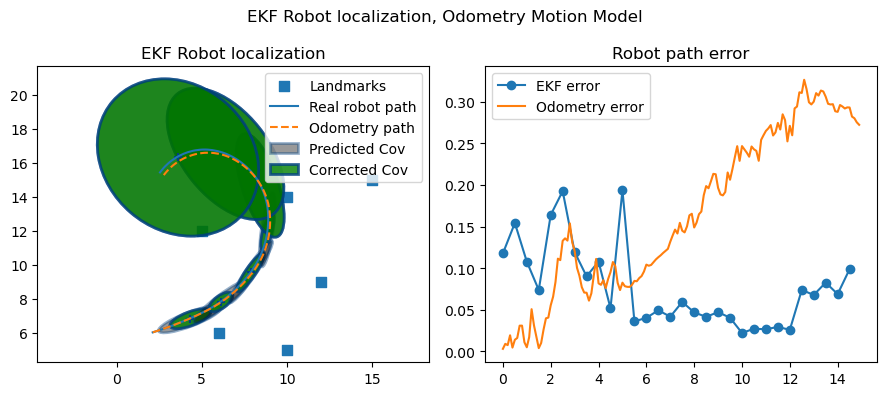

In [783]:
# set the seed to get the same results every time
np.random.seed(seed)

std_rot1 = std_bearing
std_trasl = std_range
std_rot2 = std_bearing

# Initialize the EKF
ekf = RobotEKF(
    dim_x=3,
    dim_z=2,
    dim_u=3,
    eval_gux=eval_gux_odom,
    eval_Gt=eval_Gt_odom,
    eval_Vt=eval_Vt_odom,
    eval_hx=eval_hx,
    eval_Ht=eval_Ht,
)
ekf.mu = np.array([[2, 6, 0.3]]).T  # x, y, theta
ekf.Sigma = np.diag([0.1, 0.1, 0.1])
ekf.Mt = np.diag([std_rot1**2, std_trasl**2, std_rot2**2])
ekf.Qt = np.diag([std_range**2, std_bearing**2])

run_localization_odom(
    ekf,
    ekf_dt=ekf_dt,
    landmarks=landmarks,
    std_lin_vel=std_lin_vel,
    std_ang_vel=std_ang_vel,
    std_range=std_range,
    std_bearing=std_bearing,
    ellipse_step_s=2.0,
    sim_length_s=sim_length_s,
)